# Google Play Store App Data - Analysis

For this analysis, let's pretend that we're a company that wants to launch a new app. We've brainstormed ideas and are ready to start developing the app. Because we're a new company, we want our app to have a large number of downloads in order to widely introduce our name and product.  What factors do we need to consider in order to maximize downloads?  For example, how much should we charge? Does the size of our app make a significant difference?  

In order to answer these questions, we will be analyzing data scraped from the Google Play Store in August 2018. The full data set can be found [on Kaggle](https://www.kaggle.com/lava18/google-play-store-apps). 

### Data Import and Initial Cleanup

Before we begin our analysis, we need to import and clean our data. We'll start by importing the necessary libraries, and the data itself.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import sqlite3
import seaborn as sns
%matplotlib inline

In [2]:
apps = pd.read_csv('/Users/alexustian/stacey_learning/googleplaystore.csv', skiprows=[10473])

We skipped row 10473 in our import because it contains only 14 columns instead of the expected 15. Now let's take a look at the first few rows of our data, and do some initial cleanup on anything that obviously needs it.

In [3]:
apps.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


We can start by removing the plus sign and commas from the Installs column. Additionally, the Genre column appears to contain both a primary and (sometimes) secondary genre, so we can split this into two columns.

In [4]:
apps['Installs'] = apps.Installs.str[0:-1] #removes the plus sign at the end
apps.Installs = apps.Installs.apply(lambda x: x.replace(',','')) #removes the commas

#The following three lines split the genres column into two new columns
genre_split = apps['Genres'].str.split(";")
apps['Genre1'] = genre_split.str.get(0)
apps['Genre2'] = genre_split.str.get(1)

Now let's examine the first few rows to make sure that our changes were successfully made.

In [5]:
apps.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Genre1,Genre2
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,10000,Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up,Art & Design,NaN
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,500000,Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,Art & Design,Pretend Play
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,5000000,Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up,Art & Design,NaN
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,50000000,Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up,Art & Design,NaN
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,100000,Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up,Art & Design,Creativity


The first few rows of our data set only include free apps, so we can't immediately tell what the values in that column look like.  Let's examine the unique values to see if any cleanup is necessary.

In [6]:
apps.Price.unique()

array(['0', '$4.99', '$3.99', '$6.99', '$1.49', '$2.99', '$7.99', '$5.99',
       '$3.49', '$1.99', '$9.99', '$7.49', '$0.99', '$9.00', '$5.49',
       '$10.00', '$24.99', '$11.99', '$79.99', '$16.99', '$14.99', '$1.00',
       '$29.99', '$12.99', '$2.49', '$10.99', '$1.50', '$19.99', '$15.99',
       '$33.99', '$74.99', '$39.99', '$3.95', '$4.49', '$1.70', '$8.99',
       '$2.00', '$3.88', '$25.99', '$399.99', '$17.99', '$400.00', '$3.02',
       '$1.76', '$4.84', '$4.77', '$1.61', '$2.50', '$1.59', '$6.49',
       '$1.29', '$5.00', '$13.99', '$299.99', '$379.99', '$37.99',
       '$18.99', '$389.99', '$19.90', '$8.49', '$1.75', '$14.00', '$4.85',
       '$46.99', '$109.99', '$154.99', '$3.08', '$2.59', '$4.80', '$1.96',
       '$19.40', '$3.90', '$4.59', '$15.46', '$3.04', '$4.29', '$2.60',
       '$3.28', '$4.60', '$28.99', '$2.95', '$2.90', '$1.97', '$200.00',
       '$89.99', '$2.56', '$30.99', '$3.61', '$394.99', '$1.26', '$1.20',
       '$1.04'], dtype=object)

From this, we can see that the dollar sign needs to be stripped out, and the data type needs to be changed from object to numeric.

In [7]:
apps.Price = apps.Price.apply(lambda x: x.strip('$'))
apps.Price = pd.to_numeric(apps.Price)

Let's take a quick look at the rest of our data types, to see if anything needs to be changed.

In [8]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10840 entries, 0 to 10839
Data columns (total 15 columns):
App               10840 non-null object
Category          10840 non-null object
Rating            9366 non-null float64
Reviews           10840 non-null int64
Size              10840 non-null object
Installs          10840 non-null object
Type              10839 non-null object
Price             10840 non-null float64
Content Rating    10840 non-null object
Genres            10840 non-null object
Last Updated      10840 non-null object
Current Ver       10832 non-null object
Android Ver       10838 non-null object
Genre1            10840 non-null object
Genre2            498 non-null object
dtypes: float64(2), int64(1), object(12)
memory usage: 1.3+ MB


The 'Last Updated' column should be converted to datetime, while the 'Installs' and 'Reviews' columns should be converted to numeric. 

NOTE: We will be taking a closer look at the size column later, and will do that cleanup in a subsequent section.

In [9]:
from datetime import datetime,date
apps['Last Updated'] = pd.to_datetime(apps['Last Updated'])
apps.Installs = pd.to_numeric(apps.Installs)
apps.Reviews = pd.to_numeric(apps.Reviews)

Before we begin our analysis, let's just make sure that there aren't any duplicate rows in our data. Some of the numbers (particularly in the Installs column) are quite large, so duplicate values could skew the results.

In [10]:
apps.duplicated().sum()

483

We can see from this output that there are a few hundred duplicate rows, so those can be removed.

In [11]:
apps.drop_duplicates(subset='App', keep='first', inplace=True)

### Optimal Price Point(s) to Maximize Downloads

Now that our data is cleaned up, we can work on our analysis. Let's first consider pricing.  Our end goal is to get as many people as possible to download the app, so we need to determine how to price our app in order to achieve that.

We can begin by taking a look at the values in the Price column, and running a quick plot to see how they are distributed.

In [12]:
apps.Price.unique()

array([   0.  ,    4.99,    3.99,    6.99,    1.49,    2.99,    7.99,
          5.99,    3.49,    1.99,    9.99,    7.49,    0.99,    9.  ,
          5.49,   10.  ,   24.99,   11.99,   79.99,   16.99,   14.99,
          1.  ,   29.99,   12.99,    2.49,   10.99,    1.5 ,   19.99,
         15.99,   33.99,   74.99,   39.99,    3.95,    4.49,    1.7 ,
          8.99,    2.  ,    3.88,   25.99,  399.99,   17.99,  400.  ,
          3.02,    1.76,    4.84,    4.77,    1.61,    2.5 ,    1.59,
          6.49,    1.29,    5.  ,   13.99,  299.99,  379.99,   37.99,
         18.99,  389.99,   19.9 ,    8.49,    1.75,   14.  ,    4.85,
         46.99,  109.99,  154.99,    3.08,    2.59,    4.8 ,    1.96,
         19.4 ,    3.9 ,    4.59,   15.46,    3.04,    4.29,    2.6 ,
          3.28,    4.6 ,   28.99,    2.95,    2.9 ,    1.97,  200.  ,
         89.99,    2.56,   30.99,    3.61,  394.99,    1.26,    1.2 ,
          1.04])

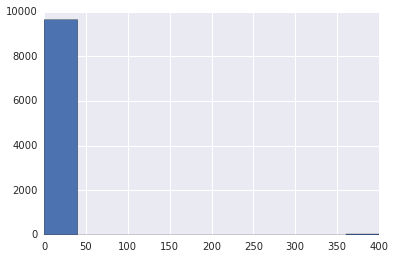

In [13]:
x = apps.Price
plt.hist(x);

We can see from the list of values that there are apps priced as high as \$399.99(!), but the histogram shows us that the vast majority of the apps are priced lower than $50.

Let's assume that our company has decided that they want to charge users for the app so that it doesn't have to be funded by ad sales, and ideally would like to charge five dollars or less. We can now focus our analysis on apps that fall in that price range, and determine how price affects the number of downloads.

We'll start by pulling out the subsection of apps priced under five dollars, and then we'll group them by price and sum the number of installs per price point.

In [14]:
apps_under_five = apps[(apps.Price < 5) & (apps.Price > 0)]

In [15]:
installs_under_five = apps_under_five.groupby('Price').Installs.sum()
print installs_under_five

Price
0.99    19387373
1.00       10500
1.04          50
1.20       10000
1.26         100
1.29        1000
1.49      293159
1.50        1000
1.59       10000
1.61        1000
1.70        2000
1.75          50
1.76          50
1.96          10
1.97       10000
1.99     4001131
2.00         560
2.49     1738831
2.50       10000
2.56        1000
2.59       10000
2.60          50
2.90      100000
2.95       10000
2.99    10190022
3.02         100
3.04          10
3.08        1000
3.28       10000
3.49      211610
3.61          10
3.88         100
3.90       10000
3.95      100000
3.99     1609251
4.29        1000
4.49      416600
4.59         100
4.60        5000
4.77       50000
4.80          10
4.84        1000
4.85          50
4.99     3434680
Name: Installs, dtype: float64


This looks good, but it would be more helpful to have the values grouped into a smaller number of "buckets" so that we can quickly see which price range to target. To do so, we'll add a column to our data frame that identifies the apps' price categories.

In [16]:
def add_price_cat(row):
    if row["Price"] == 0:
        return "Free"
    elif row["Price"] < 1:
        return "0-1 Dollar"
    elif row["Price"] < 2:
        return "1-2 Dollars"
    elif row["Price"] < 3:
        return "2-3 Dollars"
    elif row["Price"] < 4:
        return "3-4 Dollars"
    elif row["Price"] < 5:
        return "4-5 Dollars"
    else:
        return "Over Five Dollars"

apps = apps.assign(action=apps.apply(add_price_cat, axis=1))
apps.rename(columns={'action': 'Price_Cat'}, inplace=True)
apps.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Genre1,Genre2,Price_Cat
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,10000,Free,0,Everyone,Art & Design,2018-01-07,1.0.0,4.0.3 and up,Art & Design,NaN,Free
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,500000,Free,0,Everyone,Art & Design;Pretend Play,2018-01-15,2.0.0,4.0.3 and up,Art & Design,Pretend Play,Free
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,5000000,Free,0,Everyone,Art & Design,2018-08-01,1.2.4,4.0.3 and up,Art & Design,NaN,Free
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,50000000,Free,0,Teen,Art & Design,2018-06-08,Varies with device,4.2 and up,Art & Design,NaN,Free
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,100000,Free,0,Everyone,Art & Design;Creativity,2018-06-20,1.1,4.4 and up,Art & Design,Creativity,Free


From the first few rows of data we can see that the column has been added, but let's look at the unique values in that column to make sure that all classifications got applied.

In [17]:
apps.Price_Cat.unique()

array(['Free', '4-5 Dollars', '3-4 Dollars', 'Over Five Dollars',
       '1-2 Dollars', '2-3 Dollars', '0-1 Dollar'], dtype=object)

It looks like our price categorization was successful. We can now plot this data to look for trends. In order to make our plotting easier, we'll run a SQL query, which will pull a sorted table with column headers.

In [18]:
conn = sqlite3.connect("Ustian_Database.db")
conn.text_factory = str
apps.to_sql('appdata', conn, if_exists='replace')

/Library/Python/2.7/site-packages/ipykernel/__main__.py:3: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  app.launch_new_instance()


In [19]:
installs_by_price = pd.read_sql('SELECT Price_Cat, SUM(Installs) as Installs \
            FROM appdata \
            WHERE Price_Cat != "Free" \
            AND Price_Cat != "Over Five Dollars" \
            GROUP BY 1 \
            ORDER BY 1', conn)

print installs_by_price

     Price_Cat  Installs
0   0-1 Dollar  19387373
1  1-2 Dollars   4340050
2  2-3 Dollars  12060463
3  3-4 Dollars   1942081
4  4-5 Dollars   3908440


And now we can plot our data.

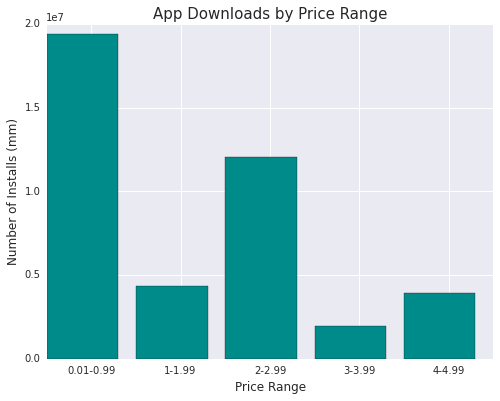

In [20]:
labels = ['0.01-0.99', '1-1.99', '2-2.99', '3-3.99','4-4.99']
x = range(len(labels))
y = installs_by_price['Installs']

plt.figure(figsize=(8, 6))
ax = plt.subplot()
plt.bar(x, y, color='darkcyan')

ax.set_xticks(range(len(labels)))
ax.set_xticks([float(n)+0.5 for n in ax.get_xticks()]) #positions the xticks in the center of the bars
ax.set_xticklabels(labels)

plt.xlabel('Price Range', fontdict = {'fontsize' : 12})
plt.ylabel('Number of Installs (mm)', fontdict = {'fontsize' : 12})
plt.title('App Downloads by Price Range', fontdict = {'fontsize' : 15});

We can see from this chart that apps priced under a dollar have the highest number of downloads, followed by apps in the \$2-2.99 range.

### Optimal App Size(s) to Maximize Downloads

Now that we know our app should be priced under \$3.00, we want to see if app size has any influence on the number of downloads.  If it does, we can keep this under consideration as we develop it.

Before we begin our analysis, let's take a closer look at the Size column, which was not cleaned up earlier.

In [21]:
apps.Size.unique()

array(['19M', '14M', '8.7M', '25M', '2.8M', '5.6M', '29M', '33M', '3.1M',
       '28M', '12M', '20M', '21M', '37M', '2.7M', '5.5M', '17M', '39M',
       '31M', '4.2M', '7.0M', '23M', '6.0M', '6.1M', '4.6M', '9.2M',
       '5.2M', '11M', '24M', 'Varies with device', '9.4M', '15M', '10M',
       '1.2M', '26M', '8.0M', '7.9M', '56M', '57M', '35M', '54M', '201k',
       '3.6M', '5.7M', '8.6M', '2.4M', '27M', '2.5M', '16M', '3.4M',
       '8.9M', '3.9M', '2.9M', '38M', '32M', '5.4M', '18M', '1.1M', '2.2M',
       '4.5M', '9.8M', '52M', '9.0M', '6.7M', '30M', '2.6M', '7.1M',
       '3.7M', '22M', '7.4M', '6.4M', '3.2M', '8.2M', '9.9M', '4.9M',
       '9.5M', '5.0M', '5.9M', '13M', '73M', '6.8M', '3.5M', '4.0M',
       '2.3M', '7.2M', '2.1M', '42M', '7.3M', '9.1M', '55M', '23k', '6.5M',
       '1.5M', '7.5M', '51M', '41M', '48M', '8.5M', '46M', '8.3M', '4.3M',
       '4.7M', '3.3M', '40M', '7.8M', '8.8M', '6.6M', '5.1M', '61M', '66M',
       '79k', '8.4M', '118k', '44M', '695k', '1.6M', '6.2M

We can quickly see that app sizes appear in both kilobytes and megabytes, and that some even use the string 'varies with device'. In order to better work with this data, we'll first change the string to NaN, and will convert the sizes to number of bytes.

The first step in this process is to split the number off from the 'k' and 'M' designations in the Size column.

In [22]:
apps['Size1'] = apps.Size.str[0:-1]
apps['Size2'] = apps.Size.str[-1:]

Now we'll convert the Size1 column to numeric values, and will have the errors (i.e., the string values) switched to NaN values.

In [23]:
apps.Size1 = pd.to_numeric(apps.Size1, errors='coerce')
apps.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Genre1,Genre2,Price_Cat,Size1,Size2
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,10000,Free,0,Everyone,Art & Design,2018-01-07,1.0.0,4.0.3 and up,Art & Design,NaN,Free,19.0,M
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,500000,Free,0,Everyone,Art & Design;Pretend Play,2018-01-15,2.0.0,4.0.3 and up,Art & Design,Pretend Play,Free,14.0,M
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,5000000,Free,0,Everyone,Art & Design,2018-08-01,1.2.4,4.0.3 and up,Art & Design,NaN,Free,8.7,M
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,50000000,Free,0,Teen,Art & Design,2018-06-08,Varies with device,4.2 and up,Art & Design,NaN,Free,25.0,M
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,100000,Free,0,Everyone,Art & Design;Creativity,2018-06-20,1.1,4.4 and up,Art & Design,Creativity,Free,2.8,M


Our columns have successfully been created, so now we need to multiply the values in the Size1 column by either 1,000 or 1,000,000, depending on the value in the Size2 column.

In [24]:
def size_convert(x, y):
    if x == 'M':
        return int(y * 1000000)
    elif x == 'k':
        return y * 1000
    else:
        return x

apps['Size'] = apps.apply(lambda x: size_convert(x.Size2, x.Size1), axis=1)
apps.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Genre1,Genre2,Price_Cat,Size1,Size2
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19000000,10000,Free,0,Everyone,Art & Design,2018-01-07,1.0.0,4.0.3 and up,Art & Design,NaN,Free,19.0,M
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14000000,500000,Free,0,Everyone,Art & Design;Pretend Play,2018-01-15,2.0.0,4.0.3 and up,Art & Design,Pretend Play,Free,14.0,M
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8700000,5000000,Free,0,Everyone,Art & Design,2018-08-01,1.2.4,4.0.3 and up,Art & Design,NaN,Free,8.7,M
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25000000,50000000,Free,0,Teen,Art & Design,2018-06-08,Varies with device,4.2 and up,Art & Design,NaN,Free,25.0,M
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2800000,100000,Free,0,Everyone,Art & Design;Creativity,2018-06-20,1.1,4.4 and up,Art & Design,Creativity,Free,2.8,M


Our conversion was successful, and the Size column now includes the total number of bytes. 

For the next step in this conversion, we will convert the Size column to a numeric data type, and will then divide each value by 1,000,000.  This way, all of the values are uniformly shown in Mbs.

In [25]:
apps.Size = pd.to_numeric(apps.Size, errors='coerce')
apps['Size_Mb'] = apps['Size'] / 1000000

Because we want to examine trends on app size, the NaN values are not currently relevant. For now we will assign these values to zero, but they will be reassigned in the function that follows.

In [26]:
apps['Size_Mb'].fillna(0, inplace=True)

As we did with the price analysis, we will now group these values into different "buckets", and then plot them to look for any trends.

In [27]:
def add_size_cat(row):
    if row["Size_Mb"] == 0:
        return "Varies"
    elif row["Size_Mb"] < 10:
        return "0.1 to 10"
    elif row["Size_Mb"] < 20:
        return "10.1 to 20"
    elif row["Size_Mb"] < 30:
        return "20.1 to 30"
    elif row["Size_Mb"] < 40:
        return "30.1 to 40"
    elif row["Size_Mb"] < 50:
        return "40.1 to 50"
    elif row["Size_Mb"] < 60:
        return "50.1 to 60"
    else:
        return "Over 60"

In [28]:
apps["Size_Cat"] = apps.apply(add_size_cat, axis=1)

In [29]:
apps.to_sql('appdata', conn, if_exists='replace')

/Library/Python/2.7/site-packages/ipykernel/__main__.py:1: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  if __name__ == '__main__':


In [30]:
installs_by_size = pd.read_sql('SELECT Size_Cat, SUM(Installs) as Installs \
            FROM appdata \
            WHERE Size_Cat != "Varies" \
            GROUP BY 1 \
            ORDER BY 1', conn)

print installs_by_size

     Size_Cat    Installs
0   0.1 to 10  4199754329
1  10.1 to 20  6204003459
2  20.1 to 30  3753239930
3  30.1 to 40  2554446882
4  40.1 to 50  2902128071
5  50.1 to 60  3374093366
6     Over 60  8414891467


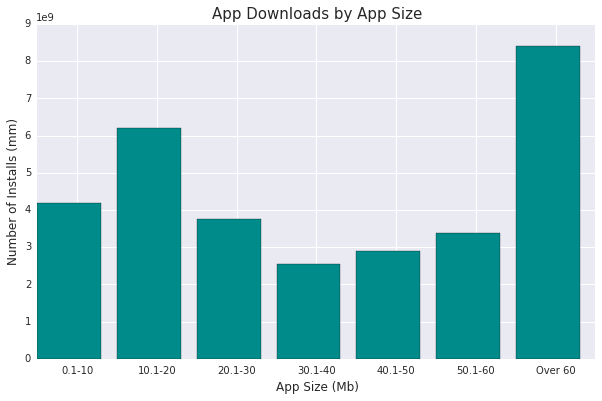

In [31]:
labels = ['0.1-10', '10.1-20', '20.1-30', '30.1-40','40.1-50', '50.1-60', 'Over 60']
x = range(len(labels))
y = installs_by_size['Installs']

plt.figure(figsize=(10, 6))
ax = plt.subplot()
plt.bar(x, y, color='darkcyan')

ax.set_xticks(range(len(labels)))
ax.set_xticks([float(n)+0.5 for n in ax.get_xticks()])
ax.set_xticklabels(labels)

plt.xlabel('App Size (Mb)', fontdict = {'fontsize' : 12})
plt.ylabel('Number of Installs (mm)', fontdict = {'fontsize' : 12})
plt.title('App Downloads by App Size', fontdict = {'fontsize' : 15});

From this, we can see that app size doesn't have quite as much impact on the number of downloads as price did.  So while we would probably want to keep our app in the 10-20Mb range, there's a little more flexibility if it's determined that the app needs to be larger than that.

### Summary

From this initial look at Google Play Store app data, our company is well on its way to planning its first app launch. In order to reach our goal of maximizing downloads (and spreading the word of our new company), we now know that the app should cost less than \$3.00, and ideally be around 10-20Mb.  

Future updates to this analysis will explore how content rating and genre impact the number of downloads.